In [ ]:
#Simulations and Benchmarking Comparison with LASSO
import numpy as np
from numpy.linalg import cholesky
from sklearn.linear_model import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from dataclasses import dataclass
import cupy as cp
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
import scipy.stats as stats
import pandas as pd
import time
#### Import SuSiE method
import rpy2.robjects as ro
from rpy2.robjects.packages import importr, data
from rpy2.robjects import numpy2ri
susie = importr('susieR')
conversion_rules = numpy2ri.converter + ro.default_converter
with (conversion_rules).context():   
    ro.r['set.seed'](1)
    N3 = data(susie).fetch('N3finemapping')['N3finemapping']
    N3_names = {v:i for i,v in enumerate(N3.names)}
    n = N3[N3_names['X']].dim[0]

# ---------------------- Config ----------------------
N = 500            # samples
P = 1000           # total features
S = 50            # number of true nonzero features ("top 200 X_i")
BLOCK = 100         # correlation block size
RHO = 0.8          # within-block AR(1) correlation
SNR = 16.0          # signal-to-noise ratio: Var(Xb)/Var(eps)
NUM_RUNS = 50       # repeat the simulation
RANDOM_200 = False # if True, choose 200 random causal features; else first 200
SEED = 1234

# ------------------- Simulation utils ----------------
def make_block_ar1_X(n, p, block=100, rho=0.6, rng=None):
    """
    Generate X with blockwise AR(1) correlation across features.
    Each block has covariance Sigma_ij = rho^{|i-j|}.
    """
    if rng is None:
        rng = np.random.default_rng()
    X = np.zeros((n, p), dtype=float)
    num_blocks = int(np.ceil(p / block))
    for b in range(num_blocks):
        s = b * block
        e = min((b + 1) * block, p)
        m = e - s
        # AR(1) covariance and Cholesky
        idx = np.arange(m)
        Sigma = rho ** np.abs(idx[:, None] - idx[None, :])
        L = cholesky(Sigma + 1e-8 * np.eye(m))
        Z = rng.standard_normal(size=(n, m))
        X[:, s:e] = Z @ L.T
    # standardize columns to mean 0, var 1
    X -= X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, ddof=1, keepdims=True)
    std[std == 0] = 1.0
    X /= std
    return X

def make_gamma_X(n, p, shape=2, scale=1, rho=0.3, block=100, rng=None):
    """
    Generate X from Gamma distribution with block correlation.
    -----------
    n : int Number of samples
    p : int Number of features
    shape, scale : float   Gamma distribution parameters
    rho : float Within-block correlation
    rng : numpy random generator
    """
    if rng is None:
        rng = np.random.default_rng()
    
    X = np.zeros((n, p), dtype=float)
    # block = BLOCK_SIZE
    num_blocks = int(np.ceil(p / block))
    
    for b in range(num_blocks):
        s = b * block
        e = min((b + 1) * block, p)
        m = e - s
        
        # Create correlation matrix
        idx = np.arange(m)
        Sigma = rho ** np.abs(idx[:, None] - idx[None, :])
        L = cholesky(Sigma + 1e-8 * np.eye(m))
        
        # Generate Gamma distribution
        Z = rng.standard_normal(size=(n, m))
        correlated_Z = Z @ L.T
        
        # Transform to uniform, then to Gamma
        uniform_samples = stats.norm.cdf(correlated_Z)
        gamma_samples = stats.gamma.ppf(uniform_samples, shape, scale=scale)
        X[:, s:e] = gamma_samples
    
    # Standardize
    X -= X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, ddof=1, keepdims=True)
    std[std == 0] = 1.0
    X /= std
    return X

def make_exponential_X(n, p, scale=1, rho=0.3,block=100, rng=None):
    """
    Generate X from Exponential distribution with block correlation.
    -----------
    n : int         Number of samples
    p : int        Number of features
    scale : float        Exponential distribution scale parameter
    rho : float        Within-block correlation
    rng : numpy random generator
    """
    if rng is None:
        rng = np.random.default_rng()
    
    X = np.zeros((n, p), dtype=float)
    num_blocks = int(np.ceil(p / block))
    
    for b in range(num_blocks):
        s = b * block
        e = min((b + 1) * block, p)
        m = e - s
        
        # Create correlation matrix
        idx = np.arange(m)
        Sigma = rho ** np.abs(idx[:, None] - idx[None, :])
        L = cholesky(Sigma + 1e-8 * np.eye(m))
        
        # Generate Exponential distribution
        Z = rng.standard_normal(size=(n, m))
        correlated_Z = Z @ L.T
        
        # Transform to uniform, then to Exponential
        uniform_samples = stats.norm.cdf(correlated_Z)
        exp_samples = stats.expon.ppf(uniform_samples, scale=scale)
        X[:, s:e] = exp_samples
    
    # Standardize
    # X -= X.mean(axis=0, keepdims=True)
    # std = X.std(axis=0, ddof=1, keepdims=True)
    # std[std == 0] = 1.0
    # X /= std
    return X

def make_multivariate_t_X(n, p, df=3, rho=0.3, block=100, rng=None):
    """
    Generate X from multivariate t-distribution with block correlation.
    -----------
    n : int        Number of samples
    p : int          Number of features
    df : int        Degrees of freedom for t-distribution (lower = heavier tails)
    rho : float        Within-block correlation
    block : int        Size of correlation blocks
    rng : numpy random generator
    """
    if rng is None:
        rng = np.random.default_rng()
    
    X = np.zeros((n, p), dtype=float)
    num_blocks = int(np.ceil(p / block))
    
    for b in range(num_blocks):
        s = b * block
        e = min((b + 1) * block, p)
        m = e - s
        
        # Create correlation matrix
        idx = np.arange(m)
        Sigma = rho ** np.abs(idx[:, None] - idx[None, :])
        L = cholesky(Sigma + 1e-8 * np.eye(m))
        
        # Generate multivariate t-distribution
        Z = rng.standard_normal(size=(n, m))
        chi2_samples = rng.chisquare(df, size=n).reshape(-1, 1)
        t_samples = Z / np.sqrt(chi2_samples / df)
        X[:, s:e] = t_samples @ L.T
    
    # Standardize
    X -= X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, ddof=1, keepdims=True)
    std[std == 0] = 0.001
    X /= (std)#/ np.sqrt(p))
    return X

def simulate_linear(X, s=100, snr=16.0, random_200=False, rng=None):
    """
    Choose s causal features, draw coefficients, create y with target SNR.
    Returns: y, beta_true, support (boolean mask).
    """
    if rng is None:
        rng = np.random.default_rng()
    n, p = X.shape
    support = np.zeros(p, dtype=bool)
    if random_200:
        idx = rng.choice(p, size=s, replace=False)
    else:
        idx = np.arange(s)  # "top 200" = first 200 columns
    support[idx] = True

    beta = np.zeros(p, dtype=float)
    # effect sizes: random signs & magnitudes
    beta[idx] = rng.choice([-1, 1], size=s) * (0.5 + rng.random(s))

    y_signal = X @ beta
    var_signal = y_signal.var()
    var_noise = var_signal / snr if snr > 0 else 1.0
    eps = rng.standard_normal(n) * np.sqrt(var_noise)
    y = y_signal + eps
    # standardize y (optional; LASSO pipeline will standardize anyway)
    return y, beta, support

def fit_lasso_select(X, y, seed=0):
    """
    LASSO with CV; return indices selected (nonzero coefficients).
    """
    pipe = make_pipeline(
        # StandardScaler(with_mean=True, with_std=True),
        # LassoCV(cv=5, n_alphas=100, random_state=seed, max_iter=10000)
        LassoCV(cv=5, alphas=200, random_state=seed, max_iter=1000)
    )
    pipe.fit(X, y)
    coef = pipe.named_steps['lassocv'].coef_
    selected = np.flatnonzero(np.abs(coef) > 1e-10)
    return selected, coef

def fit_lassolars_select(X, y, seed=0):
    """
    LASSO with CV; return indices selected (nonzero coefficients).
    """
    pipe = make_pipeline(
        # StandardScaler(with_mean=True, with_std=True),
        LassoLarsCV(cv=5, max_iter=100)
    )
    pipe.fit(X, y)
    coef = pipe.named_steps['lassolarscv'].coef_
    selected = np.flatnonzero(np.abs(coef) > 1e-10)
    return selected, coef

def fit_elasticnet_select(X, y, seed=0):
    """
    Elastic Net with CV; return indices selected (nonzero coefficients).
    Tests multiple l1_ratio values.
    """
    # from sklearn.linear_model import ElasticNetCV
    
    pipe = make_pipeline(
        # StandardScaler(with_mean=True, with_std=True),
        ElasticNetCV(cv=5, l1_ratio=0.5, 
                     alphas=100, random_state=seed, max_iter=100)
    )
    pipe.fit(X, y)
    coef = pipe.named_steps['elasticnetcv'].coef_
    selected = np.flatnonzero(np.abs(coef) > 1e-10)
    return selected, coef

@dataclass
class Metrics:
    tp: int; fp: int; fn: int; tn: int
    tpr: float; fpr: float
    selected: int; brier: float

def brier_score(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    
    # Brier score = mean((y_true - y_prob)^2)
    brier = np.mean((y_true - y_prob) ** 2)
    return brier

def calculate_brier_score(probabilities, support_mask):
    # # Extract probabilities and convert to numpy
    # probabilities = cp.asnumpy(e_moment[0][:,0])
    # Convert support mask to binary (0/1)
    true_labels = support_mask#.astype(int)
    # Calculate Brier score
    brier = brier_score(true_labels, probabilities)
    return brier


def compute_tpr_fpr(selected_idx, support_mask, prob, p_total):
    """
    TPR = TP / (#true); FPR = FP / (#null).
    """
    selected_mask = np.zeros(p_total, dtype=bool)
    selected_mask[selected_idx] = True

    tp = int(np.sum(selected_mask & support_mask))
    fp = int(np.sum(selected_mask & ~support_mask))
    fn = int(np.sum(~selected_mask & support_mask))
    tn = int(np.sum(~selected_mask & ~support_mask))

    s = int(np.sum(support_mask))
    nulls = p_total - s
    tpr = tp / s if s > 0 else np.nan
    fpr = fp / nulls if nulls > 0 else np.nan
    brier = calculate_brier_score(prob, support_mask)

    return Metrics(tp, fp, fn, tn, tpr, fpr, int(np.sum(selected_mask)), brier)

def calculate_f1_score(tp, fp, fn):
 
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

def lasso_pseudo_probabilities(coef, threshold=1e-10):
    """
    Convert LASSO coefficients to pseudo-probabilities for Brier score calculation.
    """
    abs_coef = np.abs(coef)
    max_coef = np.max(abs_coef)
    if max_coef == 0:
        return np.zeros_like(coef)
    # Normalize and apply sigmoid-like transformation
    normalized = abs_coef / max_coef
    pseudo_probs = 1 / (1 + np.exp(-10 * (normalized - 0.1)))
    return pseudo_probs

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [2]:
#Our methods

'''import torch
import torch.nn as nn
import torch.nn.functional as F'''
#cp.cuda.Device(1).use()
import random
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    cp.random.seed(seed)
set_seed(123)

class fixed_variable_selection:
    def __init__(self,data,prior):
      self.data=data
      self.p_lambda=prior[0]
      self.p_wishart=prior[1]
      self.p_probability=prior[2]

    def dot(self,A,B):
      C=cp.einsum('ijk,ikp->ijp', A, B)
      return C

    def quantity(self,data):
      X,Y=data
      N,P=X.shape
      D=Y.shape[1]
      #Q1: sum n of xni^2 P*1
      #Q2: sum of Yn*Yn^T D*D
      #Q3: sum n of xni*Yn D*P
      #Q4: sum of n xni*xnj P*P

      Q1=cp.sum(X*X,axis=0).reshape(P,1)
      Q2=cp.sum(Y.reshape(N,D,1)*Y.reshape(N,1,D),axis=0)
      Q3=cp.sum(X.reshape(N,1,P)*Y.reshape(N,D,1),axis=0)
      for i in range(N):
          if i==0:
                Q4=X[i].reshape(P,1)*X[i].reshape(1,P)
          else:
            Q4+=X[i].reshape(P,1)*X[i].reshape(1,P)
      return [Q1,Q2,Q3,Q4]


    def VI_w(self,data,E_lambda,E_w_p,E_z,p_lambda,Q):
      X,Y=data
      N,P=X.shape
      D=Y.shape[1]
      #X:N*P
      #Y:N*D
      #E_lambda:D*D
      #E_w_p:D*P
      #E_z:P*2
      #p_lambda[0]:D*D (identity matrix)

      #precision:P*D*D
      precision=Q[0].reshape(P,1,1)*E_lambda+E_z[:,0].reshape(P,1,1)*p_lambda[0]+E_z[:,1].reshape(P,1,1)*p_lambda[1]
      inv_precision=cp.linalg.inv(precision+1e-11)

      mu_i1=X.reshape(N,1,P)*E_w_p #N*D*P
      mu_inter=cp.sum(X.reshape(N,1,P)*(cp.sum(mu_i1,axis=-1,keepdims=True)-mu_i1),axis=0)-Q[2] #D*P
      mu_inter2=-cp.sum(E_lambda*cp.transpose(mu_inter).reshape(P,1,D),axis=-1).reshape(P,1,D) #P*D
      mu=cp.sum(inv_precision*mu_inter2,axis=-1) #P*D

      def Gaussian_expectation(mean,precision,inv_precision):
        E_w=mean
        E_w_2=mean.reshape(P,D,1)*mean.reshape(P,1,D)+inv_precision
        return [cp.transpose(E_w),E_w_2,mean,inv_precision] #D*P, P*D*D

      return Gaussian_expectation(mu,precision,inv_precision)


    def VI_z(self,E_w_2,p_lambda,p):
      #E_w_2:P*D*D
      #p_lambda[0]:D*D
      D=p_lambda[0].shape[0]
      #p:constant 0.5
      p_lambda1=cp.repeat(p_lambda[0].reshape(1,D,D),len(E_w_2),axis=0)
      p_lambda2=cp.repeat(p_lambda[1].reshape(1,D,D),len(E_w_2),axis=0)
     # print(E_w_2)

      z_1=0.5*cp.log(cp.linalg.det(p_lambda[0]))-0.5*cp.trace(self.dot(p_lambda1,E_w_2),axis1=-2, axis2=-1).reshape(-1,1)+cp.log(p+1e-20) #P*1
     # print(z_1)
      z_2=0.5*cp.log(cp.linalg.det(p_lambda[1]))-0.5*cp.trace(self.dot(p_lambda2,E_w_2),axis1=-2, axis2=-1).reshape(-1,1)+cp.log(1-p+1e-20) #P*1

      z=1/(1+cp.exp(z_2-z_1))
      #print(z[0])
      return cp.concatenate([z,1-z],axis=1)

    def VI_lambda(self,data,E_w,inv_precision,p_v,p_V,Q):
      X,Y=data
      N,P=X.shape
      D=Y.shape[1]

      E_w_t=cp.transpose(E_w)
      #E_w_t:P*D
      #inv_precision:P*D*D
      #p_v:constant
      #p_V:D*D

      new_v=p_v+N
      new_V_i=cp.linalg.inv(p_V)+Q[1]-cp.sum(self.dot(E_w_t.reshape(P,D,1),cp.transpose(Q[2]).reshape(P,1,D)),axis=0)\
        -cp.sum(self.dot(cp.transpose(Q[2]).reshape(P,D,1),E_w_t.reshape(P,1,D)),axis=0) #D*D

      new_V_i1=E_w_t.reshape(P,1,D,1)*E_w_t.reshape(1,P,1,D) #P*P*D*D
      for i in range(P):
        new_V_i1[i,i,:,:]+=inv_precision[i]

      new_V_i2=cp.sum(Q[3].reshape(P,P,1,1)*new_V_i1,axis=[0,1])#D*D

      new_V=(new_V_i2+cp.transpose(new_V_i2))/2+new_V_i

      def wishart_expectation(v,V):
        return [v*cp.linalg.inv(V),v,cp.linalg.inv(V)]

      return wishart_expectation(new_v,new_V)

    def variational_inference(self,max_iter,last_run,activate=True):
      if len(last_run)==0:

        def initialization():

          from sklearn import linear_model
          regr = linear_model.LinearRegression()
          regr.fit(cp.asnumpy(self.data[0]),cp.asnumpy(self.data[1]))
          regr.coef_
          i_E_w=cp.array(regr.coef_) #D*P
        #  i_E_w=cp.concatenate([beta.reshape(1,-1),cp.zeros((750,1)).reshape(1,-1)],axis=1).reshape(1,P+1)
          i_E_w_2=cp.transpose(i_E_w).reshape(-1,self.data[1].shape[1],1)*cp.transpose(i_E_w).reshape(-1,1,self.data[1].shape[1]) #P*D*D

          return i_E_w,i_E_w_2,cp.zeros_like(i_E_w_2) #inv_precision

        E_w,E_w_2,inv_precision=initialization()
        self.Q=self.quantity(self.data)

      else:

        E_w,E_w_2,inv_precision,self.p_probability,self.p_wishart=last_run

      for i in range(max_iter):
        E_lambda,c_v,c_V=self.VI_lambda(self.data,E_w,inv_precision,self.p_wishart[0],self.p_wishart[1],self.Q) #P*D*D

        E_z=self.VI_z(E_w_2,self.p_lambda,self.p_probability) #P*2
        c_E_w,E_w_2,c_mu,inv_precision=self.VI_w(self.data,E_lambda,E_w,E_z,self.p_lambda,self.Q)

        E_w=c_E_w #P*D

        Stop=self.early_stop(E_z,i,1e-5,activate)

        if Stop:
            return [E_z,E_w,E_lambda],[E_w,E_w_2,inv_precision,E_z[:,0].reshape(-1,1),[c_v,c_V]]
        if i==max_iter-1:
            return [E_z,E_w,E_lambda],[E_w,E_w_2,inv_precision,E_z[:,0].reshape(-1,1),[c_v,c_V]]


    def sampling_batch(self,iter_s,inner_iter,sub_set,activate=True):

        import random
        for i in range(iter_s):
            if i ==0:
              def initialization():
                  from sklearn import linear_model
                  regr = linear_model.LinearRegression()
                  regr.fit(cp.asnumpy(self.data[0]),cp.asnumpy(self.data[1]))
                  regr.coef_
                  i_E_w=cp.array(regr.coef_) #D*P
                #  i_E_w=cp.concatenate([beta.reshape(1,-1),cp.zeros((750,1)).reshape(1,-1)],axis=1).reshape(1,P+1)
                  i_E_w_2=cp.transpose(i_E_w).reshape(-1,self.data[1].shape[1],1)*cp.transpose(i_E_w).reshape(-1,1,self.data[1].shape[1]) #P*D*D
                  return i_E_w,i_E_w_2,cp.zeros_like(i_E_w_2) #inv_precision

              E_w,E_w_2,inv_precision=initialization()
              last_run=[E_w,E_w_2,inv_precision,self.p_probability,self.p_wishart]
              self.entire_data=self.data

              entire_order = list(range(self.entire_data[0].shape[0]))
              random.shuffle(entire_order)
              rank = entire_order[-subset:]
              del entire_order[-subset:]

              #rank=random.sample(range(0,self.entire_data[0].shape[0]),sub_set)
              self.data=[self.entire_data[0][rank],self.entire_data[1][rank]]
              self.Q=self.quantity(self.data)

              e_moment,last_run=self.variational_inference(inner_iter,last_run,False)

            else:

              rank = entire_order[-subset:]
              del entire_order[-subset:]
              if len(entire_order)<subset:
                    entire_order = list(range(self.entire_data[0].shape[0]))

              self.data=[self.entire_data[0][rank],self.entire_data[1][rank]]
              self.Q=self.quantity(self.data)

              e_moment,last_run=self.variational_inference(inner_iter,last_run,False)
            Stop=self.early_stop(e_moment[0],i,1e-5,activate=True)

            if Stop:
                return e_moment,last_run
            if i==iter_s-1:
                return e_moment,last_run


    def VIEM(self,max_iter,inner_iter):
      for i in range(max_iter):
        if i ==0:
          e_moment,last_run=self.variational_inference(inner_iter,[])
        else:
          e_moment,last_run=self.variational_inference(inner_iter,last_run)

      return e_moment

    def early_stop(self,E_z,iteration,threshold,activate=True):

        if activate:
            if iteration<5:
                if iteration==0:
                    global moving_container
                    moving_container=cp.expand_dims(E_z,axis=0)
                else:
                    moving_container=cp.concatenate([moving_container,cp.expand_dims(E_z,axis=0)],axis=0)
            else:
                MV=cp.mean(moving_container,axis=0)
                if cp.sum(MV-E_z)<threshold:
                    print('Converged')
                    return True

                else:
                    moving_container=cp.concatenate([moving_container,cp.expand_dims(E_z,axis=0)],axis=0)[1:]
        else:
            pass


def construct_prior(data,sampling=True):
    X,Y=data
    N,P=X.shape
    D=Y.shape[1]

    p=cp.repeat(cp.array([[0.5]]),P,axis=0)
    v_0=D
    V_0=cp.identity(D)

    p_lambda2=cp.sum(cp.var(Y,axis=0))*cp.identity(D)/(D*10*N)
    if cp.log(cp.array(N))>=cp.array((P*D)**2.1/(100.*N)):
        argmax=cp.log(cp.array(N))
    else:
        argmax=cp.array(((P*D)**2.1)/(100.*N))

    p_lambda1=(cp.sum(cp.var(Y,axis=0))*argmax/D)*cp.identity(D)


#     p_lambda1=5*cp.identity(D)
#     p_lambda2=0.05*cp.identity(D)
    if sampling:
        p_lambda1=P_LAMB1*cp.identity(D)
        p_lambda2=P_LAMB2*cp.identity(D)  #0.05 try
    else:
        p_lambda1=5*cp.identity(D)
        p_lambda2=0.05*cp.identity(D)
    #   print(1/p_lambda1)
    #   print(1/p_lambda2)

    return [[cp.linalg.inv(p_lambda1),cp.linalg.inv(p_lambda2)],[v_0,V_0],p]

In [3]:
test_dist = 'MultT'
all_distributions = {
	'Exp': lambda: make_exponential_X(N, P, scale=1, rho=RHO,block=BLOCK, rng=rng),
	'Gamma': lambda: make_gamma_X(N, P, shape=2, scale=1, rho=RHO,block=BLOCK, rng=rng),
	'Gaussian': lambda: make_block_ar1_X(N, P, block=BLOCK, rho=RHO, rng=rng),
	'MultT': lambda: make_multivariate_t_X(N, P, df=3, rho=RHO, block=BLOCK, rng=rng)
}
X_generator= all_distributions[test_dist]
y_generator = lambda: simulate_linear(X, s=S, snr=SNR, random_200=RANDOM_200, rng=rng)

In [6]:
# ------------------- LASSO experiment -----------------
rng = np.random.default_rng(SEED)
all_metrics_l1 = []
start_time = time.time()
for run in range(NUM_RUNS):
    # 1) simulate X and y
    X = X_generator()
    # y, beta_true, support = simulate_linear(
        # X, s=S, snr=SNR, random_200=RANDOM_200, rng=rng
    # )
    y, beta_true, support = y_generator()

    # 2) variable selection via LASSO
    ### Time recording
    
    sel_idx, coef = fit_lasso_select(X, y, seed=SEED + run)
    
    moment = lasso_pseudo_probabilities(coef, threshold=1e-10)

    # 3) metrics
    m = compute_tpr_fpr(sel_idx, support, moment, P)
    all_metrics_l1.append(m)
    f1_score = calculate_f1_score(m.tp, m.fp, m.fn)
    print(f"[run {run+1}/{NUM_RUNS}] selected={m.selected} | TP={m.tp} FP={m.fp} "
          f"FN={m.fn} TN={m.tn} | TPR={m.tpr:.3f} FPR={m.fpr:.3f} | f1={f1_score:.3f}")
consumed_time = time.time() - start_time
# 4) report averages
avg_tpr = np.mean([m.tpr for m in all_metrics_l1])
avg_fpr = np.mean([m.fpr for m in all_metrics_l1])
avg_sel = np.mean([m.selected for m in all_metrics_l1])
avg_brier_score = np.mean([m.brier for m in all_metrics_l1])
avg_f1_score = np.mean([calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_l1])
print("\n== Averages over runs ==")
print(f"avg selected: {avg_sel:.1f} | avg TPR: {avg_tpr:.3f} | avg FPR: {avg_fpr:.3f}")
print(f"avg_brier_score: {avg_brier_score}")
print(f"avg_f1_score: {avg_f1_score}")
print(f"average consumed time: {consumed_time/NUM_RUNS}")

[run 1/30] selected=233 | TP=43 FP=190 FN=7 TN=760 | TPR=0.860 FPR=0.200 | f1=0.304
[run 2/30] selected=209 | TP=45 FP=164 FN=5 TN=786 | TPR=0.900 FPR=0.173 | f1=0.347
[run 3/30] selected=147 | TP=35 FP=112 FN=15 TN=838 | TPR=0.700 FPR=0.118 | f1=0.355
[run 4/30] selected=191 | TP=41 FP=150 FN=9 TN=800 | TPR=0.820 FPR=0.158 | f1=0.340
[run 5/30] selected=280 | TP=45 FP=235 FN=5 TN=715 | TPR=0.900 FPR=0.247 | f1=0.273
[run 6/30] selected=240 | TP=43 FP=197 FN=7 TN=753 | TPR=0.860 FPR=0.207 | f1=0.297
[run 7/30] selected=99 | TP=31 FP=68 FN=19 TN=882 | TPR=0.620 FPR=0.072 | f1=0.416
[run 8/30] selected=267 | TP=45 FP=222 FN=5 TN=728 | TPR=0.900 FPR=0.234 | f1=0.284
[run 9/30] selected=133 | TP=36 FP=97 FN=14 TN=853 | TPR=0.720 FPR=0.102 | f1=0.393
[run 10/30] selected=149 | TP=37 FP=112 FN=13 TN=838 | TPR=0.740 FPR=0.118 | f1=0.372
[run 11/30] selected=273 | TP=39 FP=234 FN=11 TN=716 | TPR=0.780 FPR=0.246 | f1=0.241
[run 12/30] selected=143 | TP=32 FP=111 FN=18 TN=839 | TPR=0.640 FPR=0.1

In [7]:
# ------------------- LASSOLars experiment -----------------
rng = np.random.default_rng(SEED)
all_metrics_l1lars = []
start_time = time.time()
for run in range(NUM_RUNS):
    # 1) simulate X and y
    X = X_generator()
    y, beta_true, support = y_generator()

    # 2) variable selection via LASSO
    sel_idx, coef = fit_lassolars_select(X, y, seed=SEED + run)
    moment = lasso_pseudo_probabilities(coef, threshold=1e-10)

    # 3) metrics
    m = compute_tpr_fpr(sel_idx, support, moment, P)
    all_metrics_l1lars.append(m)
    f1_score = calculate_f1_score(m.tp, m.fp, m.fn)
    print(f"[run {run+1}/{NUM_RUNS}] selected={m.selected} | TP={m.tp} FP={m.fp} "
          f"FN={m.fn} TN={m.tn} | TPR={m.tpr:.3f} FPR={m.fpr:.3f} | f1={f1_score:.3f}")
consumed_time = time.time() - start_time
# 4) report averages
avg_tpr = np.mean([m.tpr for m in all_metrics_l1lars])
avg_fpr = np.mean([m.fpr for m in all_metrics_l1lars])
avg_sel = np.mean([m.selected for m in all_metrics_l1lars])
avg_brier_score = np.mean([m.brier for m in all_metrics_l1lars])
avg_f1_score = np.mean([calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_l1lars])
print("\n== Averages over runs ==")
print(f"avg selected: {avg_sel:.1f} | avg TPR: {avg_tpr:.3f} | avg FPR: {avg_fpr:.3f}")
print(f"avg_brier_score: {avg_brier_score}")
print(f"avg_f1_score: {avg_f1_score}")
print(f"average consumed time: {consumed_time/NUM_RUNS}")

[run 1/30] selected=92 | TP=29 FP=63 FN=21 TN=887 | TPR=0.580 FPR=0.066 | f1=0.408
[run 2/30] selected=92 | TP=33 FP=59 FN=17 TN=891 | TPR=0.660 FPR=0.062 | f1=0.465
[run 3/30] selected=84 | TP=29 FP=55 FN=21 TN=895 | TPR=0.580 FPR=0.058 | f1=0.433
[run 4/30] selected=92 | TP=38 FP=54 FN=12 TN=896 | TPR=0.760 FPR=0.057 | f1=0.535
[run 5/30] selected=90 | TP=33 FP=57 FN=17 TN=893 | TPR=0.660 FPR=0.060 | f1=0.471
[run 6/30] selected=97 | TP=35 FP=62 FN=15 TN=888 | TPR=0.700 FPR=0.065 | f1=0.476
[run 7/30] selected=93 | TP=30 FP=63 FN=20 TN=887 | TPR=0.600 FPR=0.066 | f1=0.420
[run 8/30] selected=89 | TP=33 FP=56 FN=17 TN=894 | TPR=0.660 FPR=0.059 | f1=0.475
[run 9/30] selected=84 | TP=33 FP=51 FN=17 TN=899 | TPR=0.660 FPR=0.054 | f1=0.493
[run 10/30] selected=92 | TP=36 FP=56 FN=14 TN=894 | TPR=0.720 FPR=0.059 | f1=0.507
[run 11/30] selected=94 | TP=29 FP=65 FN=21 TN=885 | TPR=0.580 FPR=0.068 | f1=0.403
[run 12/30] selected=83 | TP=27 FP=56 FN=23 TN=894 | TPR=0.540 FPR=0.059 | f1=0.406
[

In [8]:
# ------------------- Elastic Net experiment -----------------
rng = np.random.default_rng(SEED)
all_metrics_eln = []
start_time = time.time()
for run in range(NUM_RUNS):
    # 1) simulate X and y
    X = X_generator()
    y, beta_true, support = y_generator()

    # 2) variable selection via LASSO
    sel_idx, coef = fit_elasticnet_select(X, y, seed=SEED + run)
    moment = lasso_pseudo_probabilities(coef, threshold=1e-10)

    # 3) metrics
    m = compute_tpr_fpr(sel_idx, support, moment, P)
    all_metrics_eln.append(m)
    f1_score = calculate_f1_score(m.tp, m.fp, m.fn)
    print(f"[run {run+1}/{NUM_RUNS}] selected={m.selected} | TP={m.tp} FP={m.fp} "
          f"FN={m.fn} TN={m.tn} | TPR={m.tpr:.3f} FPR={m.fpr:.3f} | f1={f1_score:.3f}")
consumed_time = time.time() - start_time
# 4) report averages
avg_tpr = np.mean([m.tpr for m in all_metrics_eln])
avg_fpr = np.mean([m.fpr for m in all_metrics_eln])
avg_sel = np.mean([m.selected for m in all_metrics_eln])
avg_f1_score = np.mean([calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_eln])
print("\n== Averages over runs ==")
print(f"avg selected: {avg_sel:.1f} | avg TPR: {avg_tpr:.3f} | avg FPR: {avg_fpr:.3f}")
avg_brier_score = np.mean([m.brier for m in all_metrics_eln])
print(f"avg_brier_score: {avg_brier_score}")
print(f"avg_f1_score: {avg_f1_score}")
print(f"average consumed time: {consumed_time/NUM_RUNS}")

[run 1/30] selected=269 | TP=43 FP=226 FN=7 TN=724 | TPR=0.860 FPR=0.238 | f1=0.270


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e+00, tolerance: 1.315e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+00, tolerance: 1.315e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[run 2/30] selected=278 | TP=47 FP=231 FN=3 TN=719 | TPR=0.940 FPR=0.243 | f1=0.287


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e+00, tolerance: 2.099e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.142e+00, tolerance: 2.099e+00
  model = cd_fast.enet_coordinate_descent(


[run 3/30] selected=254 | TP=42 FP=212 FN=8 TN=738 | TPR=0.840 FPR=0.223 | f1=0.276
[run 4/30] selected=267 | TP=44 FP=223 FN=6 TN=727 | TPR=0.880 FPR=0.235 | f1=0.278
[run 5/30] selected=330 | TP=44 FP=286 FN=6 TN=664 | TPR=0.880 FPR=0.301 | f1=0.232
[run 6/30] selected=257 | TP=42 FP=215 FN=8 TN=735 | TPR=0.840 FPR=0.226 | f1=0.274
[run 7/30] selected=162 | TP=36 FP=126 FN=14 TN=824 | TPR=0.720 FPR=0.133 | f1=0.340
[run 8/30] selected=303 | TP=44 FP=259 FN=6 TN=691 | TPR=0.880 FPR=0.273 | f1=0.249
[run 9/30] selected=205 | TP=41 FP=164 FN=9 TN=786 | TPR=0.820 FPR=0.173 | f1=0.322


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e+00, tolerance: 2.018e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.657e+00, tolerance: 2.018e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[run 10/30] selected=202 | TP=40 FP=162 FN=10 TN=788 | TPR=0.800 FPR=0.171 | f1=0.317


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+00, tolerance: 1.200e+00
  model = cd_fast.enet_coordinate_descent(


[run 11/30] selected=271 | TP=37 FP=234 FN=13 TN=716 | TPR=0.740 FPR=0.246 | f1=0.231


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.693e-01, tolerance: 5.885e-01
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.492e-01, tolerance: 5.885e-01
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[run 12/30] selected=233 | TP=39 FP=194 FN=11 TN=756 | TPR=0.780 FPR=0.204 | f1=0.276


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+00, tolerance: 9.965e-01
  model = cd_fast.enet_coordinate_descent(


[run 13/30] selected=231 | TP=41 FP=190 FN=9 TN=760 | TPR=0.820 FPR=0.200 | f1=0.292
[run 14/30] selected=198 | TP=38 FP=160 FN=12 TN=790 | TPR=0.760 FPR=0.168 | f1=0.306


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+00, tolerance: 1.321e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+00, tolerance: 1.321e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[run 15/30] selected=247 | TP=43 FP=204 FN=7 TN=746 | TPR=0.860 FPR=0.215 | f1=0.290
[run 16/30] selected=279 | TP=44 FP=235 FN=6 TN=715 | TPR=0.880 FPR=0.247 | f1=0.267


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e+01, tolerance: 4.532e+00
  model = cd_fast.enet_coordinate_descent(


[run 17/30] selected=349 | TP=45 FP=304 FN=5 TN=646 | TPR=0.900 FPR=0.320 | f1=0.226
[run 18/30] selected=235 | TP=40 FP=195 FN=10 TN=755 | TPR=0.800 FPR=0.205 | f1=0.281
[run 19/30] selected=223 | TP=39 FP=184 FN=11 TN=766 | TPR=0.780 FPR=0.194 | f1=0.286
[run 20/30] selected=232 | TP=40 FP=192 FN=10 TN=758 | TPR=0.800 FPR=0.202 | f1=0.284
[run 21/30] selected=167 | TP=42 FP=125 FN=8 TN=825 | TPR=0.840 FPR=0.132 | f1=0.387
[run 22/30] selected=273 | TP=44 FP=229 FN=6 TN=721 | TPR=0.880 FPR=0.241 | f1=0.272
[run 23/30] selected=308 | TP=45 FP=263 FN=5 TN=687 | TPR=0.900 FPR=0.277 | f1=0.251


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.415e+00, tolerance: 2.144e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.201e+00, tolerance: 2.144e+00
  model = cd_fast.enet_coordinate_descent(


[run 24/30] selected=234 | TP=44 FP=190 FN=6 TN=760 | TPR=0.880 FPR=0.200 | f1=0.310
[run 25/30] selected=194 | TP=39 FP=155 FN=11 TN=795 | TPR=0.780 FPR=0.163 | f1=0.320
[run 26/30] selected=264 | TP=40 FP=224 FN=10 TN=726 | TPR=0.800 FPR=0.236 | f1=0.255
[run 27/30] selected=124 | TP=29 FP=95 FN=21 TN=855 | TPR=0.580 FPR=0.100 | f1=0.333
[run 28/30] selected=272 | TP=44 FP=228 FN=6 TN=722 | TPR=0.880 FPR=0.240 | f1=0.273


c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+00, tolerance: 2.005e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e+00, tolerance: 1.471e+00
  model = cd_fast.enet_coordinate_descent(
c:\Garage\work\mamba\envs\py312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[run 29/30] selected=274 | TP=42 FP=232 FN=8 TN=718 | TPR=0.840 FPR=0.244 | f1=0.259
[run 30/30] selected=192 | TP=37 FP=155 FN=13 TN=795 | TPR=0.740 FPR=0.163 | f1=0.306

== Averages over runs ==
avg selected: 244.2 | avg TPR: 0.823 | avg FPR: 0.214
avg_brier_score: 0.09111987519298094
avg_f1_score: 0.28490910884758414
average consumed time: 3.2197834491729735


In [26]:
P_LAMB1 = 150
P_LAMB2 = 0.01
# BLOCK_SIZE = 100

In [10]:
# ###Sim OUR methods with different lambda ###
# rng = np.random.default_rng(SEED+1)
# all_metrics_our = []
# start_time = time.time()
# lamb_start = 140
# lamb_step = 20
# P_LAMB1 = lamb_start
# X = X_generator()
# y, beta_true, support = y_generator()
# for run in range(NUM_RUNS):
#     # 1) simulate X and y
#     # X = X_generator()
#     # y, beta_true, support = y_generator()

#     # 2) variable selection via our method
#     prior = construct_prior([cp.array(X),cp.array(y.reshape(-1,1))])
#     e_moment = fixed_variable_selection([cp.array(X),cp.array(y.reshape(-1,1))], prior).VIEM(30,1)
#     sel_idx = np.flatnonzero(cp.asnumpy(e_moment[0][:, 0]) > 0.99)
#     probabilities = e_moment[0].get()[:,0]

#     # 3) metrics
#     m = compute_tpr_fpr(sel_idx, support, probabilities, P)
#     all_metrics_our.append(m)

#     f1_score = calculate_f1_score(m.tp, m.fp, m.fn)
#     print(f"[run {run+1}/{NUM_RUNS}] selected={m.selected} | TP={m.tp} FP={m.fp} "
#           f"FN={m.fn} TN={m.tn} | TPR={m.tpr:.3f} FPR={m.fpr:.3f} | F1 Score: {f1_score:.3f} | Brier Score: {m.brier:.3f}")

#     # 4) change the LAMB
#     P_LAMB1 = P_LAMB1 + lamb_step

# consumed_time = time.time() - start_time
# # 4) report averages
# avg_tpr = np.mean([m.tpr for m in all_metrics_our])
# avg_fpr = np.mean([m.fpr for m in all_metrics_our])
# avg_sel = np.mean([m.selected for m in all_metrics_our])
# avg_brier_score = np.mean([m.brier for m in all_metrics_our])
# avg_f1_score = np.mean([calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_our])
# print("\n== Averages over runs ==")
# print(f"avg selected: {avg_sel:.1f} | avg TPR: {avg_tpr:.3f} | avg FPR: {avg_fpr:.3f}")
# print(f"avg_brier_score: {avg_brier_score}")
# print(f"avg_f1_score: {avg_f1_score}")
# print(f"average consumed time: {consumed_time/NUM_RUNS}")
# ## Draw F1 and Brier score curve with coresponding LAMB
# import matplotlib.pyplot as plt

# # Assume all_metrics_our is already computed from previous runs
# # and that for each run, P_LAMB1 was incremented by 5.2 starting from 25

# # lamb_start = 20
# # lamb_step = 0.2
# num_lambs = len(all_metrics_our)

# lamb_values = [lamb_start + i * lamb_step for i in range(num_lambs)]
# f1_scores = [calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_our]
# brier_scores = [m.brier for m in all_metrics_our]
# ## Calculate variance of F1 and Brier score
# f1_scores_var = np.var(f1_scores)
# brier_scores_var = np.var(brier_scores)
# print(f"Variance of F1 score: {f1_scores_var}")
# print(f"Variance of Brier score: {brier_scores_var}")

# fig, ax1 = plt.subplots(figsize=(8,5))

# color = 'tab:blue'
# ax1.set_xlabel('P_LAMB1')
# ax1.set_ylabel('F1 Score', color=color)
# ax1.plot(lamb_values, f1_scores, marker='o', color=color, label='F1 Score')
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_title('F1 and Brier Score vs P_LAMB1')

# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.set_ylabel('Brier Score', color=color)
# ax2.plot(lamb_values, brier_scores, marker='s', color=color, label='Brier Score')
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()
# plt.show()

In [27]:
###Sim OUR methods ###
rng = np.random.default_rng(SEED)
all_metrics_our = []
start_time = time.time()
for run in range(NUM_RUNS):
    # 1) simulate X and y
    X = X_generator()
    y, beta_true, support = y_generator()

    # 2) variable selection via our method
    prior = construct_prior([cp.array(X),cp.array(y.reshape(-1,1))])
    e_moment = fixed_variable_selection([cp.array(X),cp.array(y.reshape(-1,1))], prior).VIEM(30,1)
    sel_idx = np.flatnonzero(cp.asnumpy(e_moment[0][:, 0]) > 0.99)
    probabilities = e_moment[0].get()[:,0]

    # 3) metrics
    m = compute_tpr_fpr(sel_idx, support, probabilities, P)
    all_metrics_our.append(m)

    f1_score = calculate_f1_score(m.tp, m.fp, m.fn)
    print(f"[run {run+1}/{NUM_RUNS}] selected={m.selected} | TP={m.tp} FP={m.fp} "
          f"FN={m.fn} TN={m.tn} | TPR={m.tpr:.3f} FPR={m.fpr:.3f} | F1 Score: {f1_score:.3f}")


consumed_time = time.time() - start_time
# 4) report averages
avg_tpr = np.mean([m.tpr for m in all_metrics_our])
avg_fpr = np.mean([m.fpr for m in all_metrics_our])
avg_sel = np.mean([m.selected for m in all_metrics_our])
avg_brier_score = np.mean([m.brier for m in all_metrics_our])
avg_f1_score = np.mean([calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_our])

print("\n== Averages over runs ==")
print(f"avg selected: {avg_sel:.1f} | avg TPR: {avg_tpr:.3f} | avg FPR: {avg_fpr:.3f}")
print(f"avg_brier_score: {avg_brier_score}")
print(f"avg_f1_score: {avg_f1_score}")
print(f"average consumed time: {consumed_time/NUM_RUNS}")


[run 1/30] selected=106 | TP=35 FP=71 FN=15 TN=879 | TPR=0.700 FPR=0.075 | F1 Score: 0.449
[run 2/30] selected=118 | TP=37 FP=81 FN=13 TN=869 | TPR=0.740 FPR=0.085 | F1 Score: 0.440
[run 3/30] selected=107 | TP=44 FP=63 FN=6 TN=887 | TPR=0.880 FPR=0.066 | F1 Score: 0.561
[run 4/30] selected=101 | TP=39 FP=62 FN=11 TN=888 | TPR=0.780 FPR=0.065 | F1 Score: 0.517
[run 5/30] selected=112 | TP=32 FP=80 FN=18 TN=870 | TPR=0.640 FPR=0.084 | F1 Score: 0.395
[run 6/30] selected=86 | TP=37 FP=49 FN=13 TN=901 | TPR=0.740 FPR=0.052 | F1 Score: 0.544
[run 7/30] selected=117 | TP=39 FP=78 FN=11 TN=872 | TPR=0.780 FPR=0.082 | F1 Score: 0.467
[run 8/30] selected=62 | TP=36 FP=26 FN=14 TN=924 | TPR=0.720 FPR=0.027 | F1 Score: 0.643
[run 9/30] selected=83 | TP=37 FP=46 FN=13 TN=904 | TPR=0.740 FPR=0.048 | F1 Score: 0.556
[run 10/30] selected=166 | TP=38 FP=128 FN=12 TN=822 | TPR=0.760 FPR=0.135 | F1 Score: 0.352
[run 11/30] selected=61 | TP=40 FP=21 FN=10 TN=929 | TPR=0.800 FPR=0.022 | F1 Score: 0.721
[

In [28]:
f1_scores = [calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_our]
brier_scores = [m.brier for m in all_metrics_our]
## Calculate variance of F1 and Brier score
f1_scores_var = np.var(f1_scores)
brier_scores_var = np.var(brier_scores)
print(f"Variance of F1 score: {f1_scores_var}")
print(f"Variance of Brier score: {brier_scores_var}")

Variance of F1 score: 0.01311850367908629
Variance of Brier score: 0.00133109


In [13]:
### SUSIE Simulation
rng = np.random.default_rng(SEED)
all_metrics_susie = []
start_time = time.time()
for run in range(NUM_RUNS):
	# 1) simulate X and y
	X = X_generator()
	y, beta_true, support = y_generator()

	# 2) variable selection via SuSiE
	conversion_rules = numpy2ri.converter + ro.default_converter
	with (conversion_rules).context():  
		N3[N3_names['X']] = X
		N3[N3_names['Y']] = y
		N3[N3_names['true_coef']] = np.array(support).astype(int)
		fitted = susie.susie(N3[N3_names['X']], 
							np.array(N3[N3_names['Y']]), 
							L=30
							)

	probabilities = fitted[-2]
	sel_idx = np.where(np.array(fitted[-2]) > 0.70)[0]
	m = compute_tpr_fpr(sel_idx, support, probabilities, P)
	all_metrics_susie.append(m)

	f1_score = calculate_f1_score(m.tp, m.fp, m.fn)
	print(f"[run {run+1}/{NUM_RUNS}] selected={m.selected} | TP={m.tp} FP={m.fp} "
		f"FN={m.fn} TN={m.tn} | TPR={m.tpr:.3f} FPR={m.fpr:.3f} | f1={f1_score:.3f}")

consumed_time = time.time() - start_time
# 4) report averages
avg_tpr = np.mean([m.tpr for m in all_metrics_susie])
avg_fpr = np.mean([m.fpr for m in all_metrics_susie])
avg_sel = np.mean([m.selected for m in all_metrics_susie])
avg_f1_score = np.mean([calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_susie])
print("\n== Averages over runs ==")
print(f"avg selected: {avg_sel:.1f} | avg TPR: {avg_tpr:.3f} | avg FPR: {avg_fpr:.3f}")
print(f"avg_f1_score: {avg_f1_score}")
print(f"average consumed time: {consumed_time/NUM_RUNS}")

[run 1/30] selected=12 | TP=12 FP=0 FN=38 TN=950 | TPR=0.240 FPR=0.000 | f1=0.387
[run 2/30] selected=10 | TP=10 FP=0 FN=40 TN=950 | TPR=0.200 FPR=0.000 | f1=0.333
[run 3/30] selected=11 | TP=11 FP=0 FN=39 TN=950 | TPR=0.220 FPR=0.000 | f1=0.361
[run 4/30] selected=13 | TP=13 FP=0 FN=37 TN=950 | TPR=0.260 FPR=0.000 | f1=0.413
[run 5/30] selected=10 | TP=10 FP=0 FN=40 TN=950 | TPR=0.200 FPR=0.000 | f1=0.333
[run 6/30] selected=12 | TP=12 FP=0 FN=38 TN=950 | TPR=0.240 FPR=0.000 | f1=0.387
[run 7/30] selected=11 | TP=11 FP=0 FN=39 TN=950 | TPR=0.220 FPR=0.000 | f1=0.361
[run 8/30] selected=14 | TP=14 FP=0 FN=36 TN=950 | TPR=0.280 FPR=0.000 | f1=0.438
[run 9/30] selected=16 | TP=16 FP=0 FN=34 TN=950 | TPR=0.320 FPR=0.000 | f1=0.485
[run 10/30] selected=13 | TP=13 FP=0 FN=37 TN=950 | TPR=0.260 FPR=0.000 | f1=0.413
[run 11/30] selected=13 | TP=13 FP=0 FN=37 TN=950 | TPR=0.260 FPR=0.000 | f1=0.413
[run 12/30] selected=11 | TP=11 FP=0 FN=39 TN=950 | TPR=0.220 FPR=0.000 | f1=0.361
[run 13/30] s

In [ ]:
# -------------------Export data to CSV for R -----------------
rng = np.random.default_rng(SEED)
path = './R_test_bench/'

def export_data_to_csv(X, y, beta_true, support, idx):
    
    dfX = pd.DataFrame(X)
    dfX.to_csv(path+'dataX_'+str(idx)+'.csv', index=False)
    dfy = pd.DataFrame({'y': y})
    # dfy.to_csv('dataY.csv', index=False)
    dfbeta_true = pd.DataFrame({'beta_true': beta_true})
    # dfbeta_true.to_csv('dataBetaTrue.csv', index=False)
    dfsupport = pd.DataFrame({'support': support})
    # dfsupport.to_csv('dataSupport.csv', index=False)
    pd.concat([dfy, dfbeta_true, dfsupport], axis=1).to_csv(path+'dataY_'+str(idx)+'.csv', index=False)

for run in range(NUM_RUNS):
    # 1) simulate X and y
    X = X_generator()
    y, beta_true, support = y_generator()
    export_data_to_csv(X, y, beta_true, support, run)
    # break

In [ ]:
## Embayes result received from R
rng = np.random.default_rng(SEED)
all_metrics_embayes = []

### load result from R result_EM.csv
result_list = pd.read_csv('./R_test_bench/result_EM_T_50.csv')
result_mat = result_list.to_numpy().T
for run in range(NUM_RUNS):
    
    # 2) variable selection via LASSO
    coef = result_mat[run+1]
    sel_idx = np.flatnonzero(np.abs(coef) > 1e-10)
    moment = lasso_pseudo_probabilities(coef, threshold=1e-10)

    # 3) metrics
    m = compute_tpr_fpr(sel_idx, support, moment, P)
    all_metrics_embayes.append(m)

    print(f"[run {run+1}/{NUM_RUNS}] selected={m.selected} | TP={m.tp} FP={m.fp} "
            f"FN={m.fn} TN={m.tn} | TPR={m.tpr:.3f} FPR={m.fpr:.3f}")

# 4) report averages
avg_tpr = np.mean([m.tpr for m in all_metrics_embayes])
avg_fpr = np.mean([m.fpr for m in all_metrics_embayes])
avg_sel = np.mean([m.selected for m in all_metrics_embayes])
avg_brier_score = np.mean([m.brier for m in all_metrics_embayes])
print("\n== Averages over runs ==")
print(f"avg selected: {avg_sel:.1f} | avg TPR: {avg_tpr:.3f} | avg FPR: {avg_fpr:.3f}")
print(f"avg_brier_score: {avg_brier_score}")

[run 1/30] selected=340 | TP=45 FP=295 FN=5 TN=655 | TPR=0.900 FPR=0.311
[run 2/30] selected=352 | TP=46 FP=306 FN=4 TN=644 | TPR=0.920 FPR=0.322
[run 3/30] selected=265 | TP=42 FP=223 FN=8 TN=727 | TPR=0.840 FPR=0.235
[run 4/30] selected=224 | TP=43 FP=181 FN=7 TN=769 | TPR=0.860 FPR=0.191
[run 5/30] selected=487 | TP=48 FP=439 FN=2 TN=511 | TPR=0.960 FPR=0.462
[run 6/30] selected=347 | TP=46 FP=301 FN=4 TN=649 | TPR=0.920 FPR=0.317
[run 7/30] selected=172 | TP=34 FP=138 FN=16 TN=812 | TPR=0.680 FPR=0.145
[run 8/30] selected=487 | TP=50 FP=437 FN=0 TN=513 | TPR=1.000 FPR=0.460
[run 9/30] selected=267 | TP=41 FP=226 FN=9 TN=724 | TPR=0.820 FPR=0.238
[run 10/30] selected=643 | TP=49 FP=594 FN=1 TN=356 | TPR=0.980 FPR=0.625
[run 11/30] selected=345 | TP=41 FP=304 FN=9 TN=646 | TPR=0.820 FPR=0.320
[run 12/30] selected=500 | TP=47 FP=453 FN=3 TN=497 | TPR=0.940 FPR=0.477
[run 13/30] selected=453 | TP=48 FP=405 FN=2 TN=545 | TPR=0.960 FPR=0.426
[run 14/30] selected=308 | TP=45 FP=263 FN=5 T

In [8]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
def f1_brier_comparison_boxplot_improved(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes):
    """
    Create comparison boxplots for F1 score and Brier score metrics with improved styling for scientific articles.
    
    Parameters:
    -----------
    all_metrics_l1 : list
        List of Metrics objects from LASSO method
    all_metrics_our : list
        List of Metrics objects from yEmpBVS
    all_metrics_eln : list
        List of Metrics objects from Elastic Net method
    all_metrics_l1lars : list
        List of Metrics objects from LassoLars method
    all_metrics_susie : list
        List of Metrics objects from SuSiE method
    all_metrics_embayes : list
        List of Metrics objects from EmBayes method
    """
    
    if len(all_metrics_l1) == 0 or len(all_metrics_our) == 0 or len(all_metrics_eln) == 0 or len(all_metrics_l1lars) == 0 or len(all_metrics_susie) == 0 or len(all_metrics_embayes) == 0:
        print("Missing data from one or more methods. Please ensure all blocks have been run.")
        return
    
    # Extract F1 and Brier metrics from all five methods
    # LASSO results
    lasso_tp = [m.tp for m in all_metrics_l1]
    lasso_fp = [m.fp for m in all_metrics_l1]
    lasso_fn = [m.fn for m in all_metrics_l1]
    lasso_f1 = [calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_l1]
    lasso_brier = [m.brier for m in all_metrics_l1]
    
    # Elastic Net results
    elasticnet_tp = [m.tp for m in all_metrics_eln]
    elasticnet_fp = [m.fp for m in all_metrics_eln]
    elasticnet_fn = [m.fn for m in all_metrics_eln]
    elasticnet_f1 = [calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_eln]
    elasticnet_brier = [m.brier for m in all_metrics_eln]
    
    # LassoLars results
    lassolars_tp = [m.tp for m in all_metrics_l1lars]
    lassolars_fp = [m.fp for m in all_metrics_l1lars]
    lassolars_fn = [m.fn for m in all_metrics_l1lars]
    lassolars_f1 = [calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_l1lars]
    lassolars_brier = [m.brier for m in all_metrics_l1lars]
    
    # SuSiE results
    susie_tp = [m.tp for m in all_metrics_susie]
    susie_fp = [m.fp for m in all_metrics_susie]
    susie_fn = [m.fn for m in all_metrics_susie]
    susie_f1 = [calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_susie]
    susie_brier = [m.brier for m in all_metrics_susie]
    
    # EmBayes results
    embayes_tp = [m.tp for m in all_metrics_embayes]
    embayes_fp = [m.fp for m in all_metrics_embayes]
    embayes_fn = [m.fn for m in all_metrics_embayes]
    embayes_f1 = [calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_embayes]
    embayes_brier = [m.brier for m in all_metrics_embayes]
    
    # EmpBVS results
    our_tp = [m.tp for m in all_metrics_our]
    our_fp = [m.fp for m in all_metrics_our]
    our_fn = [m.fn for m in all_metrics_our]
    our_f1 = [calculate_f1_score(m.tp, m.fp, m.fn) for m in all_metrics_our]
    our_brier = [m.brier for m in all_metrics_our]
    
    # Create F1 and Brier comparison boxplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 4),dpi=320)
    fig.suptitle(f'Multivariate $T$-distribution: p={format(P, ",d")}, s={format(S, ",d")}', fontsize=16, fontweight='bold')
    
    # Define professional colors - dim for baseline methods, bright for EmpBVS
    # colors = ['#8B8B8B', '#A0A0A0', '#B0B0B0', '#C0C0C0', '#D0D0D0', '#D0A0A0']  # Gray scale + red highlight
    f1colors = ['#0c3c5f', '#0c3c5f', '#0c3c5f', '#0c3c5f', '#0c3c5f', '#0c3c5f'] # Gray scale + red highlight
    # F1 Score comparison
    f1_data = [lasso_f1, elasticnet_f1, lassolars_f1, susie_f1, embayes_f1, our_f1]
    f1_labels = ['LASSO', 'ElasticNet', 'LassoLars', 'SuSiE', 'EM Bayes', 'EmpBVS']
    
    bp1 = axes[0].boxplot(f1_data, tick_labels=f1_labels, patch_artist=True, showcaps=False,
                          widths=0.7,  # Reduce box width
                          boxprops=dict(linewidth=1.2),
                          whiskerprops=dict(linewidth=1.2),
                        #   capprops=dict(linewidth=1.2),
                          flierprops=dict(marker='+', markerfacecolor=f1colors[0], markeredgecolor=f1colors[0], markersize=4),
                          medianprops=dict(linewidth=1.6, color='black'))

    # Apply colors
    for patch, color in zip(bp1['boxes'], f1colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # axes[0].set_title('F1', fontsize=12)
    axes[0].set_ylabel('F1 Score', fontsize=14, rotation=270, verticalalignment='top')
    axes[0].grid(True, alpha=0.2)
    axes[0].tick_params(axis='x', rotation=270, labelsize=12)
    
    # Brier Score comparison
    briercolors = ['#2a9d8f', '#2a9d8f', '#2a9d8f', '#2a9d8f', '#2a9d8f', '#2a9d8f']
    brier_data = [lasso_brier, elasticnet_brier, lassolars_brier, susie_brier, embayes_brier, our_brier]
    brier_labels = ['LASSO', 'ElasticNet', 'LassoLars', 'SuSiE', 'EM Bayes', 'EmpBVS']
    
    bp2 = axes[1].boxplot(brier_data, tick_labels=brier_labels, patch_artist=True, showcaps=False,
                          widths=0.7,  # Reduce box width
                          boxprops=dict(linewidth=1.2),
                          whiskerprops=dict(linewidth=1.2),
                        #   capprops=dict(linewidth=0),
                          flierprops=dict(marker='+', markerfacecolor=briercolors[0], markeredgecolor=briercolors[0], markersize=4),
                          medianprops=dict(linewidth=1.6, color='black')
                          )
                          
    # Apply colors
    for patch, color in zip(bp2['boxes'], briercolors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # axes[1].set_title('Brier', fontsize=12)
    axes[1].set_ylabel('Brier Score', fontsize=14, rotation=270, verticalalignment='top')
    axes[1].grid(True, alpha=0.2)
    axes[1].tick_params(axis='x', rotation=270, labelsize=12)
       
    plt.tight_layout()
    # plt.subplots_adjust(top=0.9)  # Add space for title
    plt.show()

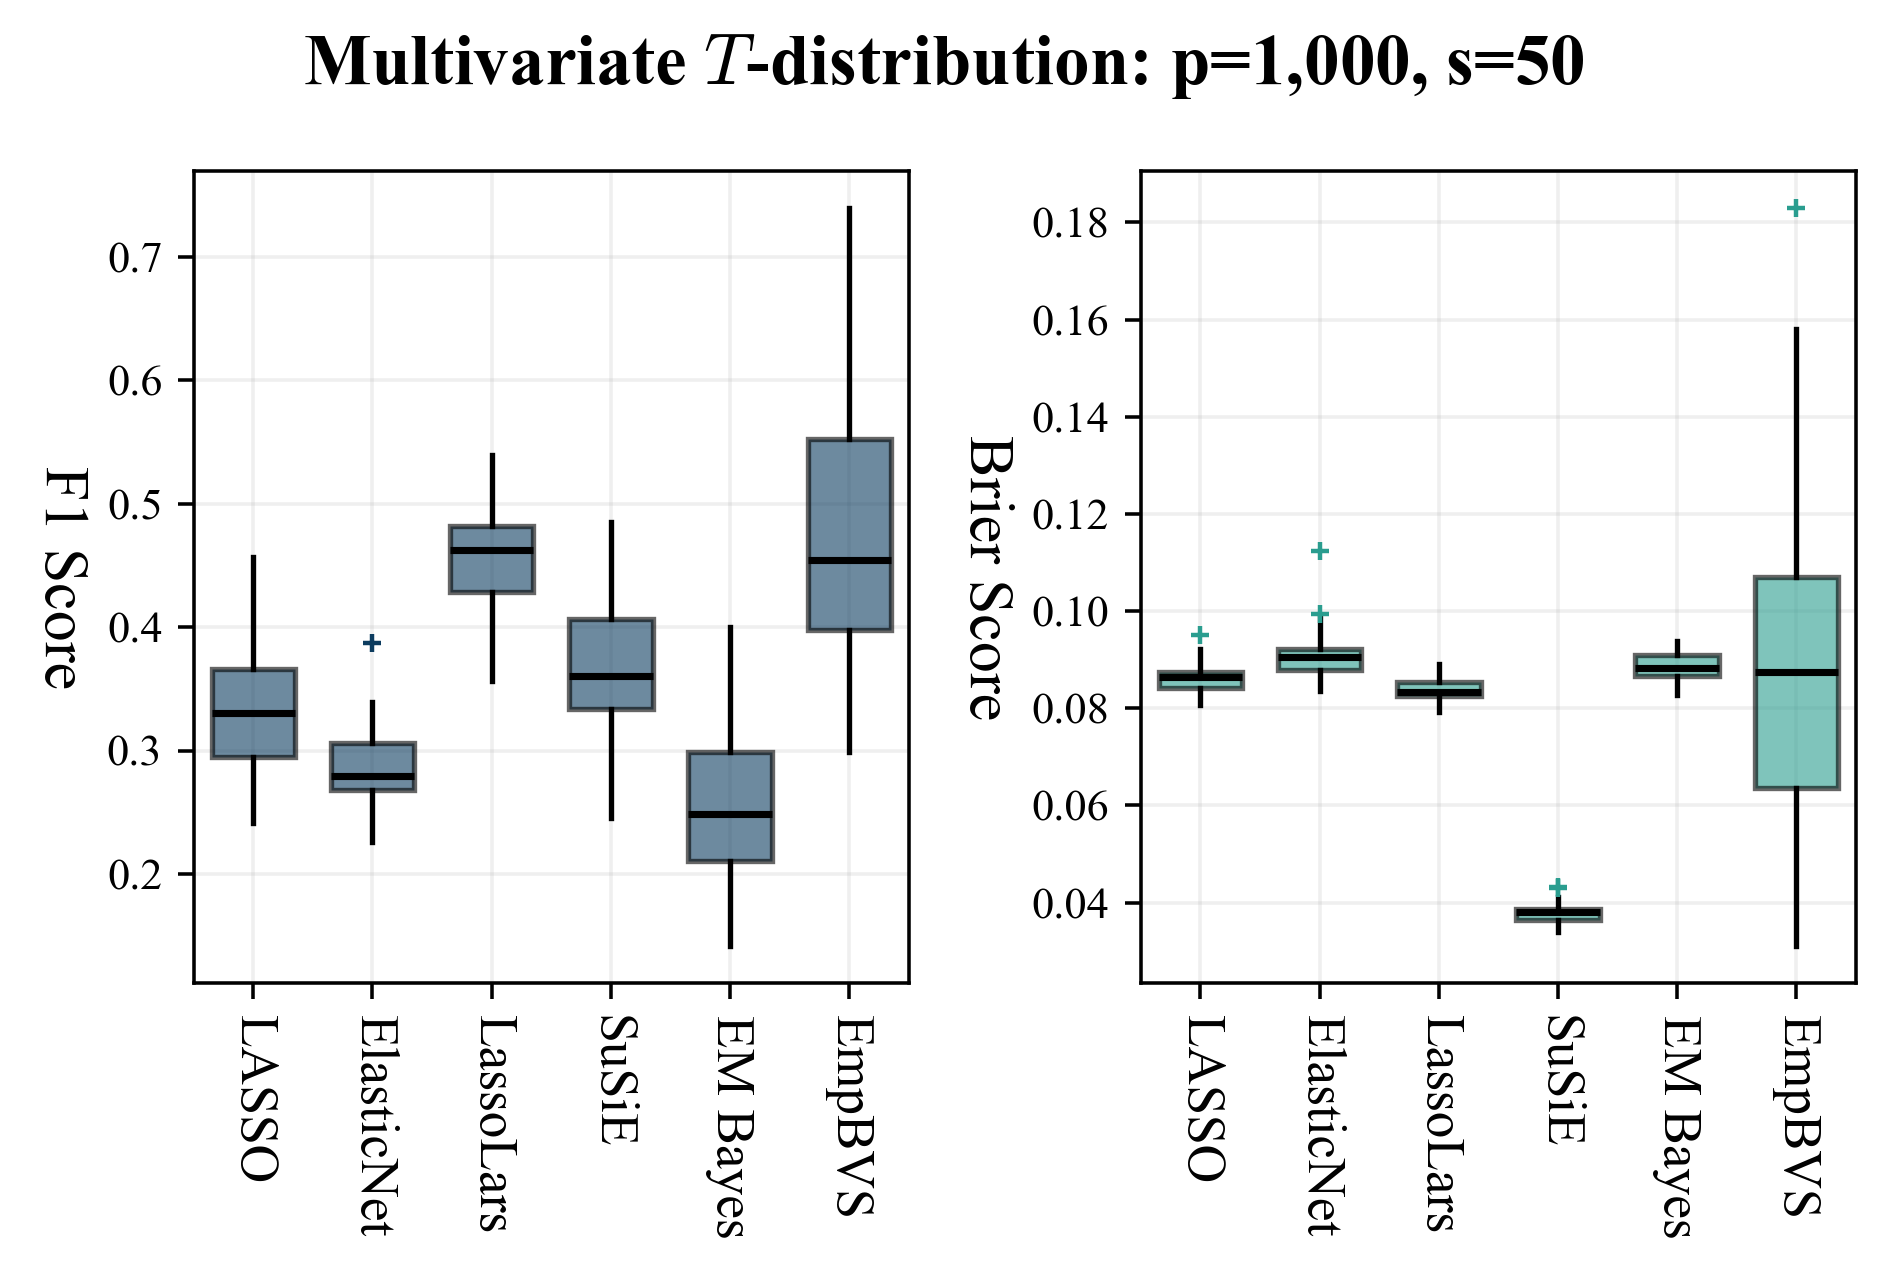

In [9]:
# For F1 and Brier score comparison:
f1_brier_comparison_boxplot_improved(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)

In [ ]:
def tpr_fpr_comparison_boxplot_improved(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes):
    """
    Create comparison boxplots for TPR and FPR metrics with improved styling for scientific articles.
    
    Parameters:
    -----------
    all_metrics_l1 : list
        List of Metrics objects from LASSO method
    all_metrics_our : list
        List of Metrics objects from your method
    all_metrics_eln : list
        List of Metrics objects from Elastic Net method
    all_metrics_l1lars : list
        List of Metrics objects from LassoLars method
    all_metrics_susie : list
        List of Metrics objects from SuSiE method
    all_metrics_embayes : list
        List of Metrics objects from Embayes method
    """
    
    if len(all_metrics_l1) == 0 or len(all_metrics_our) == 0 or len(all_metrics_eln) == 0 or len(all_metrics_l1lars) == 0 or len(all_metrics_susie) == 0 or len(all_metrics_embayes) == 0:
        print("Missing data from one or more methods. Please ensure all blocks have been run.")
        return
    
    # Extract TPR and FPR metrics from all five methods
    # LASSO results
    lasso_tpr = [m.tpr for m in all_metrics_l1]
    lasso_fpr = [m.fpr for m in all_metrics_l1]
    
    # Elastic Net results
    elasticnet_tpr = [m.tpr for m in all_metrics_eln]
    elasticnet_fpr = [m.fpr for m in all_metrics_eln]
    
    # LassoLars results
    lassolars_tpr = [m.tpr for m in all_metrics_l1lars]
    lassolars_fpr = [m.fpr for m in all_metrics_l1lars]
    
    # SuSiE results
    susie_tpr = [m.tpr for m in all_metrics_susie]
    susie_fpr = [m.fpr for m in all_metrics_susie]
    
    # Embayes results
    embayes_tpr = [m.tpr for m in all_metrics_embayes]
    embayes_fpr = [m.fpr for m in all_metrics_embayes]
    
    # Your method results
    our_tpr = [m.tpr for m in all_metrics_our]
    our_fpr = [m.fpr for m in all_metrics_our]
    
    # Create TPR and FPR comparison boxplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('TPR and FPR Comparison: LASSO vs Elastic Net vs LassoLars vs SuSiE vs Embayes vs Our Method', fontsize=14)
    
    # Define professional colors - dim for baseline methods, bright for our method
    colors = ['#8B8B8B', '#A0A0A0', '#B0B0B0', '#C0C0C0', '#D0D0D0', '#FF6B6B']  # Gray scale + red highlight
    
    # TPR comparison
    tpr_data = [lasso_tpr, elasticnet_tpr, lassolars_tpr, susie_tpr, embayes_tpr, our_tpr]
    tpr_labels = ['LASSO', 'Elastic Net', 'LassoLars', 'SuSiE', 'Embayes', 'Our Method']
    
    bp1 = axes[0].boxplot(tpr_data, tick_labels=tpr_labels, patch_artist=True, 
                          widths=0.6,  # Reduce box width
                          boxprops=dict(linewidth=1.2),
                          whiskerprops=dict(linewidth=1.2),
                          capprops=dict(linewidth=1.2),
                          medianprops=dict(linewidth=1.5))
    
    # Apply colors
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    
    axes[0].set_title('True Positive Rate (TPR)', fontsize=12)
    axes[0].set_ylabel('TPR', fontsize=11)
    axes[0].grid(True, alpha=0.2)
    axes[0].tick_params(axis='x', rotation=45, labelsize=10)
    
    # FPR comparison
    fpr_data = [lasso_fpr, elasticnet_fpr, lassolars_fpr, susie_fpr, embayes_fpr, our_fpr]
    fpr_labels = ['LASSO', 'Elastic Net', 'LassoLars', 'SuSiE', 'Embayes', 'Our Method']
    
    bp2 = axes[1].boxplot(fpr_data, tick_labels=fpr_labels, patch_artist=True,
                          widths=0.6,  # Reduce box width
                          boxprops=dict(linewidth=1.2),
                          whiskerprops=dict(linewidth=1.2),
                          capprops=dict(linewidth=1.2),
                          medianprops=dict(linewidth=1.5))
    
    # Apply colors
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    
    axes[1].set_title('False Positive Rate (FPR)', fontsize=12)
    axes[1].set_ylabel('FPR', fontsize=11)
    axes[1].grid(True, alpha=0.2)
    axes[1].tick_params(axis='x', rotation=45, labelsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Add space for title
    plt.show()
    
    # Summary statistics for TPR and FPR
    print("\n=== TPR and FPR Summary Statistics ===")
    print("LASSO Method:")
    print(f"  TPR: {np.mean(lasso_tpr):.3f} ± {np.std(lasso_tpr):.3f}")
    print(f"  FPR: {np.mean(lasso_fpr):.3f} ± {np.std(lasso_fpr):.3f}")
    
    print("\nElastic Net Method:")
    print(f"  TPR: {np.mean(elasticnet_tpr):.3f} ± {np.std(elasticnet_tpr):.3f}")
    print(f"  FPR: {np.mean(elasticnet_fpr):.3f} ± {np.std(elasticnet_fpr):.3f}")
    
    print("\nLassoLars Method:")
    print(f"  TPR: {np.mean(lassolars_tpr):.3f} ± {np.std(lassolars_tpr):.3f}")
    print(f"  FPR: {np.mean(lassolars_fpr):.3f} ± {np.std(lassolars_fpr):.3f}")
    
    print("\nSuSiE Method:")
    print(f"  TPR: {np.mean(susie_tpr):.3f} ± {np.std(susie_tpr):.3f}")
    print(f"  FPR: {np.mean(susie_fpr):.3f} ± {np.std(susie_fpr):.3f}")
    
    print("\nEmbayes Method:")
    print(f"  TPR: {np.mean(embayes_tpr):.3f} ± {np.std(embayes_tpr):.3f}")
    print(f"  FPR: {np.mean(embayes_fpr):.3f} ± {np.std(embayes_fpr):.3f}")
    
    print("\nOur Method:")
    print(f"  TPR: {np.mean(our_tpr):.3f} ± {np.std(our_tpr):.3f}")
    print(f"  FPR: {np.mean(our_fpr):.3f} ± {np.std(our_fpr):.3f}")
    
    # Statistical tests for TPR and FPR
    print("\n=== TPR and FPR Statistical Tests ===")
    
    import scipy.stats as stats
    
    # TPR tests
    tpr_lasso_our_stat, tpr_lasso_our_p = stats.ttest_ind(lasso_tpr, our_tpr)
    tpr_lasso_elasticnet_stat, tpr_lasso_elasticnet_p = stats.ttest_ind(lasso_tpr, elasticnet_tpr)
    tpr_lasso_lassolars_stat, tpr_lasso_lassolars_p = stats.ttest_ind(lasso_tpr, lassolars_tpr)
    tpr_lasso_susie_stat, tpr_lasso_susie_p = stats.ttest_ind(lasso_tpr, susie_tpr)
    tpr_lasso_embayes_stat, tpr_lasso_embayes_p = stats.ttest_ind(lasso_tpr, embayes_tpr)
    tpr_our_elasticnet_stat, tpr_our_elasticnet_p = stats.ttest_ind(our_tpr, elasticnet_tpr)
    tpr_our_lassolars_stat, tpr_our_lassolars_p = stats.ttest_ind(our_tpr, lassolars_tpr)
    tpr_our_susie_stat, tpr_our_susie_p = stats.ttest_ind(our_tpr, susie_tpr)
    tpr_our_embayes_stat, tpr_our_embayes_p = stats.ttest_ind(our_tpr, embayes_tpr)
    tpr_elasticnet_lassolars_stat, tpr_elasticnet_lassolars_p = stats.ttest_ind(elasticnet_tpr, lassolars_tpr)
    tpr_elasticnet_susie_stat, tpr_elasticnet_susie_p = stats.ttest_ind(elasticnet_tpr, susie_tpr)
    tpr_elasticnet_embayes_stat, tpr_elasticnet_embayes_p = stats.ttest_ind(elasticnet_tpr, embayes_tpr)
    tpr_lassolars_susie_stat, tpr_lassolars_susie_p = stats.ttest_ind(lassolars_tpr, susie_tpr)
    tpr_lassolars_embayes_stat, tpr_lassolars_embayes_p = stats.ttest_ind(lassolars_tpr, embayes_tpr)
    tpr_susie_embayes_stat, tpr_susie_embayes_p = stats.ttest_ind(susie_tpr, embayes_tpr)
    
    print(f"TPR t-tests:")
    print(f"  LASSO vs Our Method: statistic={tpr_lasso_our_stat:.3f}, p-value={tpr_lasso_our_p:.3f}")
    print(f"  LASSO vs Elastic Net: statistic={tpr_lasso_elasticnet_stat:.3f}, p-value={tpr_lasso_elasticnet_p:.3f}")
    print(f"  LASSO vs LassoLars: statistic={tpr_lasso_lassolars_stat:.3f}, p-value={tpr_lasso_lassolars_p:.3f}")
    print(f"  LASSO vs SuSiE: statistic={tpr_lasso_susie_stat:.3f}, p-value={tpr_lasso_susie_p:.3f}")
    print(f"  LASSO vs Embayes: statistic={tpr_lasso_embayes_stat:.3f}, p-value={tpr_lasso_embayes_p:.3f}")
    print(f"  Our Method vs Elastic Net: statistic={tpr_our_elasticnet_stat:.3f}, p-value={tpr_our_elasticnet_p:.3f}")
    print(f"  Our Method vs LassoLars: statistic={tpr_our_lassolars_stat:.3f}, p-value={tpr_our_lassolars_p:.3f}")
    print(f"  Our Method vs SuSiE: statistic={tpr_our_susie_stat:.3f}, p-value={tpr_our_susie_p:.3f}")
    print(f"  Our Method vs Embayes: statistic={tpr_our_embayes_stat:.3f}, p-value={tpr_our_embayes_p:.3f}")
    print(f"  Elastic Net vs LassoLars: statistic={tpr_elasticnet_lassolars_stat:.3f}, p-value={tpr_elasticnet_lassolars_p:.3f}")
    print(f"  Elastic Net vs SuSiE: statistic={tpr_elasticnet_susie_stat:.3f}, p-value={tpr_elasticnet_susie_p:.3f}")
    print(f"  Elastic Net vs Embayes: statistic={tpr_elasticnet_embayes_stat:.3f}, p-value={tpr_elasticnet_embayes_p:.3f}")
    print(f"  LassoLars vs SuSiE: statistic={tpr_lassolars_susie_stat:.3f}, p-value={tpr_lassolars_susie_p:.3f}")
    print(f"  LassoLars vs Embayes: statistic={tpr_lassolars_embayes_stat:.3f}, p-value={tpr_lassolars_embayes_p:.3f}")
    print(f"  SuSiE vs Embayes: statistic={tpr_susie_embayes_stat:.3f}, p-value={tpr_susie_embayes_p:.3f}")
    
    # FPR tests
    fpr_lasso_our_stat, fpr_lasso_our_p = stats.ttest_ind(lasso_fpr, our_fpr)
    fpr_lasso_elasticnet_stat, fpr_lasso_elasticnet_p = stats.ttest_ind(lasso_fpr, elasticnet_fpr)
    fpr_lasso_lassolars_stat, fpr_lasso_lassolars_p = stats.ttest_ind(lasso_fpr, lassolars_fpr)
    fpr_lasso_susie_stat, fpr_lasso_susie_p = stats.ttest_ind(lasso_fpr, susie_fpr)
    fpr_lasso_embayes_stat, fpr_lasso_embayes_p = stats.ttest_ind(lasso_fpr, embayes_fpr)
    fpr_our_elasticnet_stat, fpr_our_elasticnet_p = stats.ttest_ind(our_fpr, elasticnet_fpr)
    fpr_our_lassolars_stat, fpr_our_lassolars_p = stats.ttest_ind(our_fpr, lassolars_fpr)
    fpr_our_susie_stat, fpr_our_susie_p = stats.ttest_ind(our_fpr, susie_fpr)
    fpr_our_embayes_stat, fpr_our_embayes_p = stats.ttest_ind(our_fpr, embayes_fpr)
    fpr_elasticnet_lassolars_stat, fpr_elasticnet_lassolars_p = stats.ttest_ind(elasticnet_fpr, lassolars_fpr)
    fpr_elasticnet_susie_stat, fpr_elasticnet_susie_p = stats.ttest_ind(elasticnet_fpr, susie_fpr)
    fpr_elasticnet_embayes_stat, fpr_elasticnet_embayes_p = stats.ttest_ind(elasticnet_fpr, embayes_fpr)
    fpr_lassolars_susie_stat, fpr_lassolars_susie_p = stats.ttest_ind(lassolars_fpr, susie_fpr)
    fpr_lassolars_embayes_stat, fpr_lassolars_embayes_p = stats.ttest_ind(lassolars_fpr, embayes_fpr)
    fpr_susie_embayes_stat, fpr_susie_embayes_p = stats.ttest_ind(susie_fpr, embayes_fpr)
    
    print(f"\nFPR t-tests:")
    print(f"  LASSO vs Our Method: statistic={fpr_lasso_our_stat:.3f}, p-value={fpr_lasso_our_p:.3f}")
    print(f"  LASSO vs Elastic Net: statistic={fpr_lasso_elasticnet_stat:.3f}, p-value={fpr_lasso_elasticnet_p:.3f}")
    print(f"  LASSO vs LassoLars: statistic={fpr_lasso_lassolars_stat:.3f}, p-value={fpr_lasso_lassolars_p:.3f}")
    print(f"  LASSO vs SuSiE: statistic={fpr_lasso_susie_stat:.3f}, p-value={fpr_lasso_susie_p:.3f}")
    print(f"  LASSO vs Embayes: statistic={fpr_lasso_embayes_stat:.3f}, p-value={fpr_lasso_embayes_p:.3f}")
    print(f"  Our Method vs Elastic Net: statistic={fpr_our_elasticnet_stat:.3f}, p-value={fpr_our_elasticnet_p:.3f}")
    print(f"  Our Method vs LassoLars: statistic={fpr_our_lassolars_stat:.3f}, p-value={fpr_our_lassolars_p:.3f}")
    print(f"  Our Method vs SuSiE: statistic={fpr_our_susie_stat:.3f}, p-value={fpr_our_susie_p:.3f}")
    print(f"  Our Method vs Embayes: statistic={fpr_our_embayes_stat:.3f}, p-value={fpr_our_embayes_p:.3f}")
    print(f"  Elastic Net vs LassoLars: statistic={fpr_elasticnet_lassolars_stat:.3f}, p-value={fpr_elasticnet_lassolars_p:.3f}")
    print(f"  Elastic Net vs SuSiE: statistic={fpr_elasticnet_susie_stat:.3f}, p-value={fpr_elasticnet_susie_p:.3f}")
    print(f"  Elastic Net vs Embayes: statistic={fpr_elasticnet_embayes_stat:.3f}, p-value={fpr_elasticnet_embayes_p:.3f}")
    print(f"  LassoLars vs SuSiE: statistic={fpr_lassolars_susie_stat:.3f}, p-value={fpr_lassolars_susie_p:.3f}")
    print(f"  LassoLars vs Embayes: statistic={fpr_lassolars_embayes_stat:.3f}, p-value={fpr_lassolars_embayes_p:.3f}")
    print(f"  SuSiE vs Embayes: statistic={fpr_susie_embayes_stat:.3f}, p-value={fpr_susie_embayes_p:.3f}")
    
    # Performance summary for TPR and FPR
    print("\n=== TPR and FPR Performance Summary ===")
    
    methods = ['LASSO', 'Elastic Net', 'LassoLars', 'SuSiE', 'Embayes', 'Our Method']
    tpr_means = [np.mean(lasso_tpr), np.mean(elasticnet_tpr), np.mean(lassolars_tpr), np.mean(susie_tpr), np.mean(embayes_tpr), np.mean(our_tpr)]
    fpr_means = [np.mean(lasso_fpr), np.mean(elasticnet_fpr), np.mean(lassolars_fpr), np.mean(susie_fpr), np.mean(embayes_fpr), np.mean(our_fpr)]
    
    best_tpr = methods[np.argmax(tpr_means)]
    best_fpr = methods[np.argmin(fpr_means)]  # Lower is better
    
    print(f"Best TPR: {best_tpr} ({max(tpr_means):.3f})")
    print(f"Best FPR: {best_fpr} ({min(fpr_means):.3f})")


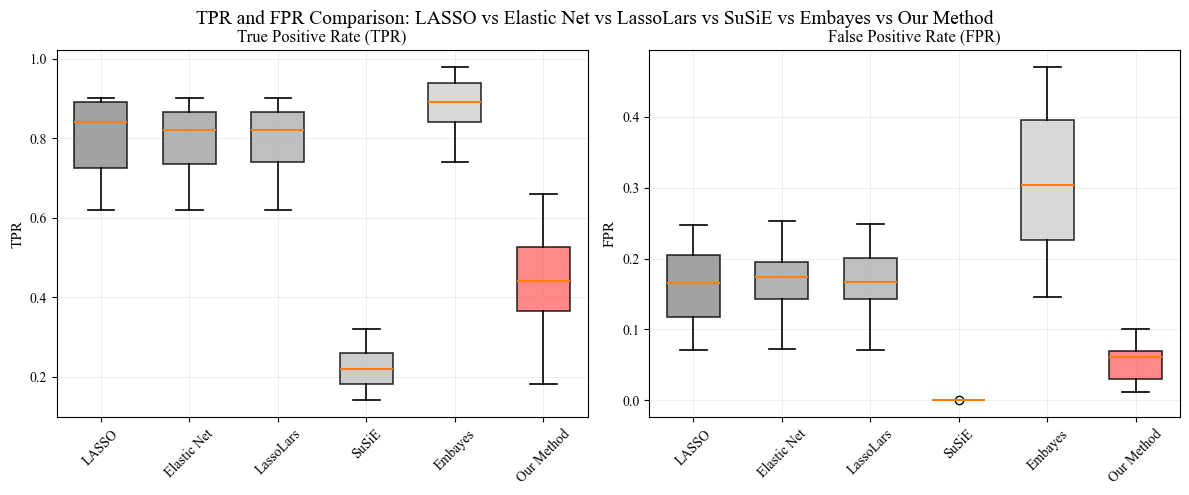


=== TPR and FPR Summary Statistics ===
LASSO Method:
  TPR: 0.802 ± 0.095
  FPR: 0.163 ± 0.056

Elastic Net Method:
  TPR: 0.800 ± 0.089
  FPR: 0.169 ± 0.046

LassoLars Method:
  TPR: 0.800 ± 0.084
  FPR: 0.168 ± 0.047

SuSiE Method:
  TPR: 0.218 ± 0.047
  FPR: 0.000 ± 0.000

Embayes Method:
  TPR: 0.888 ± 0.069
  FPR: 0.311 ± 0.102

Our Method:
  TPR: 0.434 ± 0.140
  FPR: 0.054 ± 0.028

=== TPR and FPR Statistical Tests ===
TPR t-tests:
  LASSO vs Our Method: statistic=6.528, p-value=0.000
  LASSO vs Elastic Net: statistic=0.055, p-value=0.957
  LASSO vs LassoLars: statistic=0.057, p-value=0.955
  LASSO vs SuSiE: statistic=21.742, p-value=0.000
  LASSO vs Embayes: statistic=-2.728, p-value=0.011
  Our Method vs Elastic Net: statistic=-8.399, p-value=0.000
  Our Method vs LassoLars: statistic=-8.596, p-value=0.000
  Our Method vs SuSiE: statistic=6.014, p-value=0.000
  Our Method vs Embayes: statistic=-11.487, p-value=0.000
  Elastic Net vs LassoLars: statistic=-0.000, p-value=1.000
 

In [ ]:
# For TPR and FPR comparison:
tpr_fpr_comparison_boxplot_improved(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)

In [4]:
##### Save fucntion########
import pickle
import os
from datetime import datetime

def save_metrics_data(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, 
                     all_metrics_susie, all_metrics_embayes, filename=None, directory="saved_metrics"):
    """
    Save all metrics data to a pickle file for later recovery.
    
    Parameters:
    -----------
    all_metrics_l1 : list
        List of Metrics objects from LASSO method
    all_metrics_our : list
        List of Metrics objects from your method
    all_metrics_eln : list
        List of Metrics objects from Elastic Net method
    all_metrics_l1lars : list
        List of Metrics objects from LassoLars method
    all_metrics_susie : list
        List of Metrics objects from SuSiE method
    all_metrics_embayes : list
        List of Metrics objects from Embayes method
    filename : str, optional
        Custom filename. If None, generates timestamp-based filename
    directory : str, optional
        Directory to save the file. Default is "saved_metrics"
    
    Returns:
    --------
    str : Path to the saved file
    """
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    
    # Generate filename if not provided
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"metrics_data_{timestamp}.pkl"
    
    # Ensure .pkl extension
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    # Full file path
    filepath = os.path.join(directory, filename)
    
    # Prepare data dictionary
    metrics_data = {
        'all_metrics_l1': all_metrics_l1,
        'all_metrics_our': all_metrics_our,
        'all_metrics_eln': all_metrics_eln,
        'all_metrics_l1lars': all_metrics_l1lars,
        'all_metrics_susie': all_metrics_susie,
        'all_metrics_embayes': all_metrics_embayes,
        'timestamp': datetime.now().isoformat(),
        'method_names': ['LASSO', 'Our Method', 'Elastic Net', 'LassoLars', 'SuSiE', 'Embayes']
    }
    
    # Save to file
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(metrics_data, f)
        
        print(f"Successfully saved metrics data to: {filepath}")
        print(f"Saved {len(all_metrics_l1)} LASSO results")
        print(f"Saved {len(all_metrics_our)} Our Method results")
        print(f"Saved {len(all_metrics_eln)} Elastic Net results")
        print(f"Saved {len(all_metrics_l1lars)} LassoLars results")
        print(f"Saved {len(all_metrics_susie)} SuSiE results")
        print(f"Saved {len(all_metrics_embayes)} Embayes results")
        
        return filepath
        
    except Exception as e:
        print(f"Error saving metrics data: {e}")
        return None

def load_metrics_data(filepath):
    """
    Load metrics data from a pickle file.
    
    Parameters:
    -----------
    filepath : str
        Path to the pickle file containing metrics data
    
    Returns:
    --------
    dict : Dictionary containing all metrics data and metadata
    """
    
    try:
        with open(filepath, 'rb') as f:
            metrics_data = pickle.load(f)
        
        print(f"Successfully loaded metrics data from: {filepath}")
        print(f"Data saved on: {metrics_data.get('timestamp', 'Unknown')}")
        print(f"Methods included: {metrics_data.get('method_names', 'Unknown')}")
        print(f"Loaded {len(metrics_data['all_metrics_l1'])} LASSO results")
        print(f"Loaded {len(metrics_data['all_metrics_our'])} Our Method results")
        print(f"Loaded {len(metrics_data['all_metrics_eln'])} Elastic Net results")
        print(f"Loaded {len(metrics_data['all_metrics_l1lars'])} LassoLars results")
        print(f"Loaded {len(metrics_data['all_metrics_susie'])} SuSiE results")
        print(f"Loaded {len(metrics_data['all_metrics_embayes'])} Embayes results")
        
        return metrics_data
        
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None
    except Exception as e:
        print(f"Error loading metrics data: {e}")
        return None

def list_saved_metrics(directory="saved_metrics"):
    """
    List all saved metrics files in the directory.
    
    Parameters:
    -----------
    directory : str, optional
        Directory to search for saved files. Default is "saved_metrics"
    
    Returns:
    --------
    list : List of file paths
    """
    
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist")
        return []
    
    pkl_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    
    if not pkl_files:
        print(f"No saved metrics files found in {directory}")
        return []
    
    print(f"Found {len(pkl_files)} saved metrics files in {directory}:")
    for i, file in enumerate(sorted(pkl_files), 1):
        filepath = os.path.join(directory, file)
        file_size = os.path.getsize(filepath)
        print(f"  {i}. {file} ({file_size:,} bytes)")
    
    return [os.path.join(directory, f) for f in sorted(pkl_files)]

# Usage examples:
print("=== Metrics Save/Load Functions ===")
print("To save your current metrics data:")
print("save_metrics_data(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)")
print()
print("To load saved metrics data:")
print("data = load_metrics_data('saved_metrics/metrics_data_20231201_143022.pkl')")
print("all_metrics_l1 = data['all_metrics_l1']")
print("all_metrics_our = data['all_metrics_our']")
print("# ... etc for other methods")
print()
print("To list all saved files:")
print("list_saved_metrics()")


=== Metrics Save/Load Functions ===
To save your current metrics data:
save_metrics_data(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)

To load saved metrics data:
data = load_metrics_data('saved_metrics/metrics_data_20231201_143022.pkl')
all_metrics_l1 = data['all_metrics_l1']
all_metrics_our = data['all_metrics_our']
# ... etc for other methods

To list all saved files:
list_saved_metrics()


In [5]:
def restore_metrics_from_file(filepath):
    """
    Convenience function to load metrics data and restore all variables.
    
    Parameters:
    -----------
    filepath : str
        Path to the pickle file containing metrics data
    
    Returns:
    --------
    tuple : (all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)
    """
    
    data = load_metrics_data(filepath)
    
    if data is None:
        return None
    
    # Extract all metrics
    all_metrics_l1 = data['all_metrics_l1']
    all_metrics_our = data['all_metrics_our']
    all_metrics_eln = data['all_metrics_eln']
    all_metrics_l1lars = data['all_metrics_l1lars']
    all_metrics_susie = data['all_metrics_susie']
    all_metrics_embayes = data['all_metrics_embayes']
    
    print("\nAll metrics variables have been restored!")
    print("You can now use them in your plotting functions:")
    print("tpr_fpr_comparison_boxplot(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)")
    print("f1_brier_comparison_boxplot(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)")
    
    return all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes

# Example usage for quick restoration:
print("\n=== Quick Restoration Example ===")
print("To quickly restore all metrics variables:")
print("all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes = restore_metrics_from_file('saved_metrics/metrics_data_20231201_143022.pkl')")
print()
print("Or to see what files are available first:")
print("list_saved_metrics()")



=== Quick Restoration Example ===
To quickly restore all metrics variables:
all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes = restore_metrics_from_file('saved_metrics/metrics_data_20231201_143022.pkl')

Or to see what files are available first:
list_saved_metrics()


In [6]:
# # Save with custom filename
# save_metrics_data(all_metrics_l1, all_metrics_our, all_metrics_eln, 
#                  all_metrics_l1lars, all_metrics_susie, all_metrics_embayes, 
#                  filename="Metrics_results_T_50_n")

In [7]:
# Quick restoration (recommended)
all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes = restore_metrics_from_file('saved_metrics/Metrics_results_T_50_n.pkl')

# Or load into a dictionary first
# data = load_metrics_data('saved_metrics/metrics_data_20231201_143022.pkl')
# all_metrics_l1 = data['all_metrics_l1']
# ... etc

Successfully loaded metrics data from: saved_metrics/Metrics_results_T_50_n.pkl
Data saved on: 2025-09-22T08:59:57.586672
Methods included: ['LASSO', 'Our Method', 'Elastic Net', 'LassoLars', 'SuSiE', 'Embayes']
Loaded 30 LASSO results
Loaded 30 Our Method results
Loaded 30 Elastic Net results
Loaded 30 LassoLars results
Loaded 30 SuSiE results
Loaded 30 Embayes results

All metrics variables have been restored!
You can now use them in your plotting functions:
tpr_fpr_comparison_boxplot(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)
f1_brier_comparison_boxplot(all_metrics_l1, all_metrics_our, all_metrics_eln, all_metrics_l1lars, all_metrics_susie, all_metrics_embayes)
